# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Change base dir

In [2]:
import os
root = '/content/drive/MyDrive/sentiment_ananlysis'
os.chdir(root)

# Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [4]:
def plot_class_distribution(df, target_col):
    print(f"Dataset Size: {df.shape[0]}")
    le = LabelEncoder()
    le.fit(df[target_col].tolist())
    class_dict = dict([[le.classes_[i], i] for i in range(len(le.classes_))])
    print(class_dict)
    
    class_weights = df[target_col].value_counts()/df.shape[0]
    class_weights = dict(class_weights)
    
    Y = df.copy()
    plt.rcParams["figure.figsize"] = (13,7)
    Y["Class"] = Y[target_col].apply(lambda x: class_dict[x])
    total = len(Y)*1
    ax=sns.countplot(x=target_col, data=Y)
    for p in ax.patches:
            ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.3, p.get_height()+30))
#     for p in ax.patches:
#             ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+150))

    #put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
    ax.yaxis.set_ticks(np.linspace(0, total, 11))

    #adjust the ticklabel to the desired format, without changing the position of the ticks. 
    ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
    plt.show()
    
    
def create_fold_df(df, target_col, n_fold):
    
    le = LabelEncoder()
    le.fit(df[target_col].tolist())
    class_dict = dict([[le.classes_[i], i] for i in range(len(le.classes_))])
    print(class_dict)
    df[target_col] = le.transform(df[target_col].tolist())
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print("Number of folds: ", skf.get_n_splits(df))

    fold_col_value = [0 for i in range(df.shape[0])]
    for i, split in enumerate(skf.split(df, df[target_col])):
        for j in split[1]:
            fold_col_value[j] = i
    df['fold'] = fold_col_value

    return df


# EDA

In [5]:
os.listdir()

['feedback_data_part_1.xlsx',
 'feedback_data_part_2.xlsx',
 '__pycache__',
 'logs',
 'models',
 '.ipynb_checkpoints',
 'feedback_dataset.csv',
 'feedback_dataset_folds.csv',
 'trainer.py',
 'pred_df.csv',
 'inference',
 'sentiment_analysis.ipynb',
 'eda_feedback_dataset.ipynb']

## Reading data

In [6]:
# df = pd.read_excel('feedback_data_part_1.xlsx')
df = pd.concat([pd.read_excel('feedback_data_part_1.xlsx'), pd.read_excel('feedback_data_part_2.xlsx')])
df.shape

(27583, 4)

In [ ]:
df.tail()

,Feedback1,positive,wow1,negative
26822,NaN,NaN,NaN,NaN
26823,NaN,NaN,NaN,NaN
26824,NaN,NaN,NaN,NaN
26825,NaN,NaN,NaN,NaN
26826,NaN,NaN,NaN,NaN


In [ ]:
# type(df.iloc[26826].Feedback1)

In [ ]:
# str(df.iloc[26826].Feedback1) == 'nan'

## Removing duplicates

In [7]:
df = df[~df.duplicated()]
df.shape

(2467, 4)

## Removing null values

In [8]:
df.isnull().sum()

Feedback1    1
positive     1
wow1         1
negative     1
dtype: int64

In [9]:
df = df.dropna()
df.shape

(2466, 4)

## Preprocessing

In [10]:
print(dict(df.positive.value_counts()))
print(dict(df.wow1.value_counts()))
print(dict(df.negative.value_counts()))

{0.0: 1704, 1.0: 762}
{0.0: 2215, 1.0: 251}
{0.0: 2376, 1.0: 90}


In [11]:
sentiment = []

for row in df.iterrows():
  if int(row[1].positive) == 1 and  int(row[1].wow1) == 1:
    sentiment.append('positive+wow')
  elif int(row[1].positive) == 1 and  int(row[1].negative) == 1:
    sentiment.append('positive+negative')
  elif int(row[1].positive) == 1:
    sentiment.append('positive')
  elif int(row[1].negative) == 1:
    sentiment.append('negative')
  else:
    # print(row[1].Feedback1)
    # print(row[1].positive, row[1].wow1, row[1].negative)
    sentiment.append('none')
  
df['sentiment'] = sentiment

In [12]:
df = df[['Feedback1', 'sentiment']]
df.columns = ['feedback', 'sentiment']

## Plots

Dataset Size: 2466
{'negative': 0, 'none': 1, 'positive': 2, 'positive+negative': 3, 'positive+wow': 4}


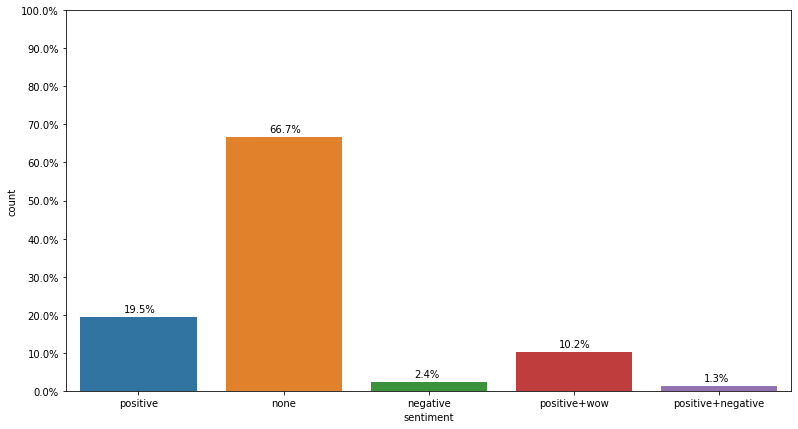

In [13]:
plot_class_distribution(df, target_col='sentiment')

In [14]:
print(dict(df.sentiment.value_counts()))

{'none': 1645, 'positive': 480, 'positive+wow': 251, 'negative': 59, 'positive+negative': 31}


In [ ]:
# **As none feature count is so high we are downsampling none feature similar to positive**
# none_sample_size = 480
# df = pd.concat([df[~(df['sentiment'] == 'none')], df[(df['sentiment'] == 'none')].sample(n=none_sample_size, random_state=42)])

In [15]:
# Saving
df.to_csv('feedback_dataset.csv', index=False)

Dataset Size: 2466
{'negative': 0, 'none': 1, 'positive': 2, 'positive+negative': 3, 'positive+wow': 4}


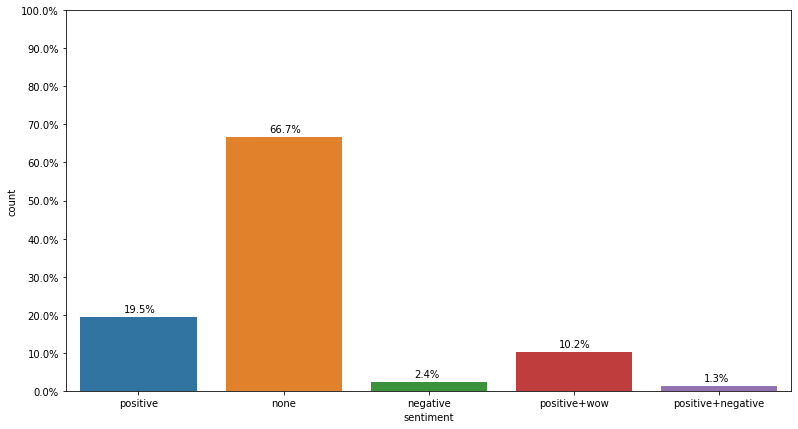

In [ ]:
plot_class_distribution(df, target_col='sentiment')

## Creating folds

In [16]:
df_folds = create_fold_df(df, target_col='sentiment', n_fold=10)

{'negative': 0, 'none': 1, 'positive': 2, 'positive+negative': 3, 'positive+wow': 4}
Number of folds:  5


In [17]:
df_folds.head()

,feedback,sentiment,fold
0,nothing you done was great. thank you. my.,2,0
1,the phone system kept cutting out hard to unde...,1,4
2,everything was great. samuel was very helpful....,2,4
3,everything was done great had no problem no is...,2,4
4,everything was great.,2,2


In [18]:
df_folds.sentiment.nunique()

5

In [19]:
df_folds.to_csv('feedback_dataset_folds.csv', index=False)

In [20]:
df_folds.shape

(2466, 3)